In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from collections import defaultdict
import os
import PIL
from scipy.io import wavfile
import torchaudio
from IPython.display import Audio, display

In [2]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!mkdir .kaggle
!mv kaggle.json .kaggle/
!mv .kaggle ~/

In [4]:
!kaggle datasets download drgfreeman/rockpaperscissors
!unzip rockpaperscissors.zip

 94% 289M/306M [00:12<00:00, 20.6MB/s]
100% 306M/306M [00:12<00:00, 25.7MB/s]
Archive:  rockpaperscissors.zip
  inflating: README_rpc-cv-images.txt  
  inflating: paper/04l5I8TqdzF9WDMJ.png  
  inflating: paper/0Og76sl5CJhbxWWx.png  
  inflating: paper/0RA9rcrv8iVvuDDU.png  
  inflating: paper/0Uomd0HvOB33m47I.png  
  inflating: paper/0a3UtNzl5Ll3sq8K.png  
  inflating: paper/0cb6cVL8pkfi4wF6.png  
  inflating: paper/0eqArS2GgsBeqgSn.png  
  inflating: paper/0t08v9bAaA0mXGCQ.png  
  inflating: paper/0vugygEjxQJPr9yz.png  
  inflating: paper/0zKU6wEhT2cDe9j0.png  
  inflating: paper/14K62H4KG1hg5qiJ.png  
  inflating: paper/1Dfw5FRlS4h60JPX.png  
  inflating: paper/1Frbe8cdOdkciOBg.png  
  inflating: paper/1Tt9U9SzrOm98Xtw.png  
  inflating: paper/1fKclJk4eBWOQSR1.png  
  inflating: paper/1jHtb93pI8f6pfKo.png  
  inflating: paper/1oKnUgV2CdCaQUUX.png  
  inflating: paper/1uoW7QcH2qAgCTxv.png  
  inflating: paper/1yKjzquSvl9ShK7K.png  
  inflating: paper/1yeoLbmp4alVOtFv.png  
  inflatin

In [5]:
def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")

In [6]:
# Esto tampoco se necesita modificar.
# OPTIONAL:
# Se puede aumentar más transformaciones (data augmentation) o cambiar el tamaño del resizing.
img_transform = torchvision.transforms.Compose([
  torchvision.transforms.RandomRotation(15),
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.Resize((224,224)),
  torchvision.transforms.ToTensor()
])

In [7]:
!mkdir data

In [8]:
!mv paper data

In [9]:
!mv rock data

In [10]:
!mv scissors data

In [11]:
# Este seria nuestro dataset con todas la imagenes
dataset = torchvision.datasets.ImageFolder("data",transform=img_transform)

# Aqui dividimos el dataset en training y testing 
N = len(dataset)
train_size = int(N * 0.8)
test_size = N - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size,test_size])

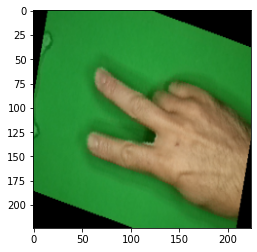

In [12]:
# Esto es solo para poder ver un ejemplo de las imagenes que se estan usando
plt.imshow(train_ds[10][0].numpy().transpose(1,2,0))

In [13]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=128, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=128, shuffle=True)

In [14]:
model = nn.Sequential(
    nn.Conv2d(3,32,kernel_size=3),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Conv2d(32,128,kernel_size=3),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Flatten(),
    nn.Linear(86528,256),
    nn.ReLU(inplace=True),
    nn.Linear(256,3)
).to(dev)

In [15]:
# Esto tampoco se necesita modificar
# OPTIONAL:
# Se puede aumentar o disminuir el learning rate para observar como es la evolucion de los accuracy y loss.

crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.01)
train(model,train_dl, test_dl, crit, optim, epochs=10)

epoch: 0, train loss: 1.2173091726643699, train acc: 40.4%, test loss: 1.0845973491668701, test acc: 33.333333333333336%
epoch: 1, train loss: 0.958542104278292, train acc: 54.628571428571426%, test loss: 1.0221275091171265, test acc: 51.36986301369863%
epoch: 2, train loss: 0.8856530572686877, train acc: 59.31428571428572%, test loss: 0.8461660593748093, test acc: 76.94063926940639%
epoch: 3, train loss: 0.6769964907850538, train acc: 73.48571428571428%, test loss: 0.5309355407953262, test acc: 86.0730593607306%
epoch: 4, train loss: 0.5979128841842923, train acc: 75.54285714285714%, test loss: 0.4839933291077614, test acc: 88.12785388127854%
epoch: 5, train loss: 0.5147144475153514, train acc: 79.77142857142857%, test loss: 0.5233568549156189, test acc: 75.34246575342466%
epoch: 6, train loss: 0.3731267622538975, train acc: 86.05714285714286%, test loss: 0.29194971174001694, test acc: 88.81278538812785%
epoch: 7, train loss: 0.3089507243462971, train acc: 88.97142857142858%, test los

2


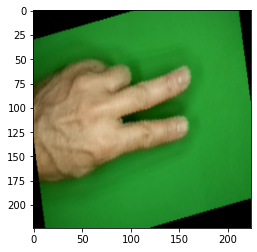

In [17]:
model.eval()
# idx = 10
idx = 100
x, y = test_ds[idx]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()
print(pred)
plt.imshow(x_numpy)